In [ ]:
# music_analyzer.py
# --- STEP 1: Import Libraries ---
import pandas as pd
import numpy as np 
import re
import sqlite3
import os
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
import pickle

# Uncomment if needed
# !pip install wordcloud
# !pip install textblob
# !pip install nltk
# nltk.download('stopwords')

In [ ]:
# --- STEP 2: Data Acquisition for New Dataset ---
data_file_path = os.path.join("resources", "tcc_ceds_music.csv")
df = pd.read_csv(data_file_path)

print("Data loaded successfully from:", data_file_path)
print("Columns in the CSV:", df.columns.tolist())

# Create a copy so that the base data remains unchanged
df_processed = df.copy()

# Back up the original CSV data for safekeeping
original_csv_backup = os.path.join("resources", "original_tcc_ceds_music.csv")
df.to_csv(original_csv_backup, index=False)
print("Original CSV data backed up as:", original_csv_backup)

# Connect to a SQLite database (database stored in the resources folder)
db_path = os.path.join("resources", "music_lyrics.db")
conn = sqlite3.connect(db_path)
df_processed.to_sql("raw_music", conn, if_exists="replace", index=False)
print("Raw data stored in SQL database at:", db_path)

Data loaded successfully from: resources\spotify_millsongdata.csv
Columns in the CSV: ['artist', 'song', 'link', 'text']
Original CSV data backed up as: resources\original_spotify_millsongdata.csv
Raw data stored in SQL database at: resources\music_lyrics.db


In [ ]:
# --- STEP 3: Text Preprocessing ---
stop_words = set(stopwords.words("english"))

def clean_text(text):
    if pd.isna(text):
        return ""
    # Lowercase
    text = text.lower()
    # Remove punctuation via regex
    text = re.sub(r"[^\w\s]", "", text)
    # Tokenize and remove stop words
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Make sure the dataset has a 'lyrics' column
if "lyrics" not in df_processed.columns:
    raise KeyError("The dataset must have a column named 'lyrics'. Please update the code accordingly.")

df_processed["clean_lyrics"] = df_processed["lyrics"].apply(lambda x: clean_text(str(x)))
print("Lyric cleaning complete.")

Text cleaning complete.


In [ ]:
# --- STEP 4: Sentiment Analysis using TextBlob ---
def get_sentiment(text):
    # Polarity ranges from -1 (negative) to 1 (positive)
    return TextBlob(text).sentiment.polarity

df_processed["sentiment_score"] = df_processed["clean_lyrics"].apply(get_sentiment)
print("Sentiment scores calculated using TextBlob.")

# Create a binary sentiment label: 1 for positive/neutral, 0 for negative.
df_processed["sentiment_label"] = df_processed["sentiment_score"].apply(lambda x: 1 if x >= 0 else 0)

KeyboardInterrupt: 

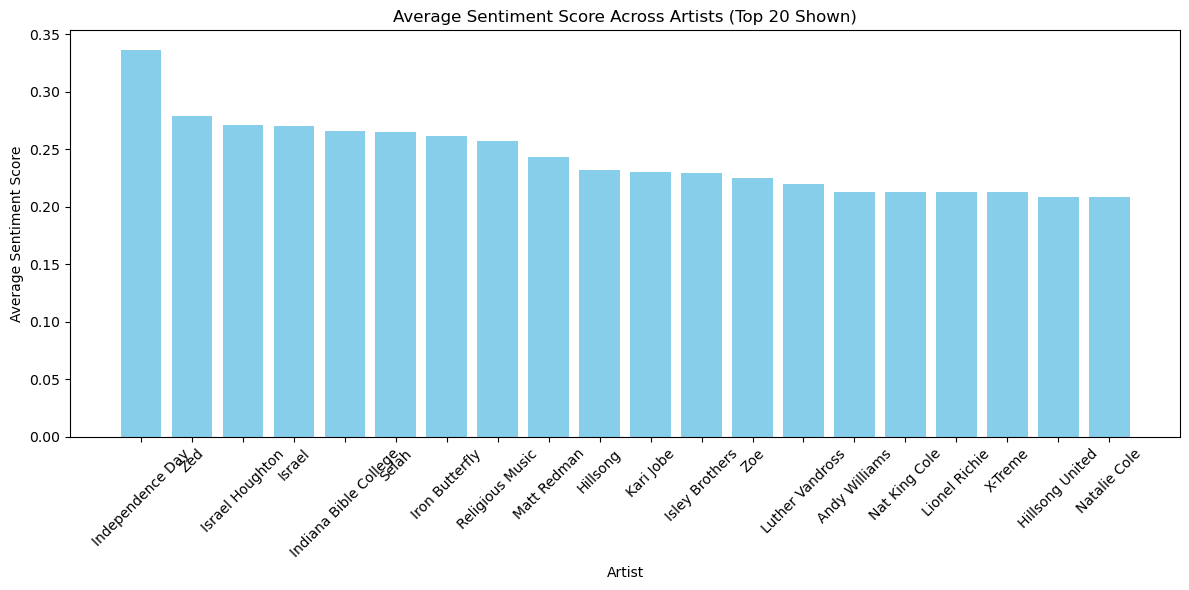

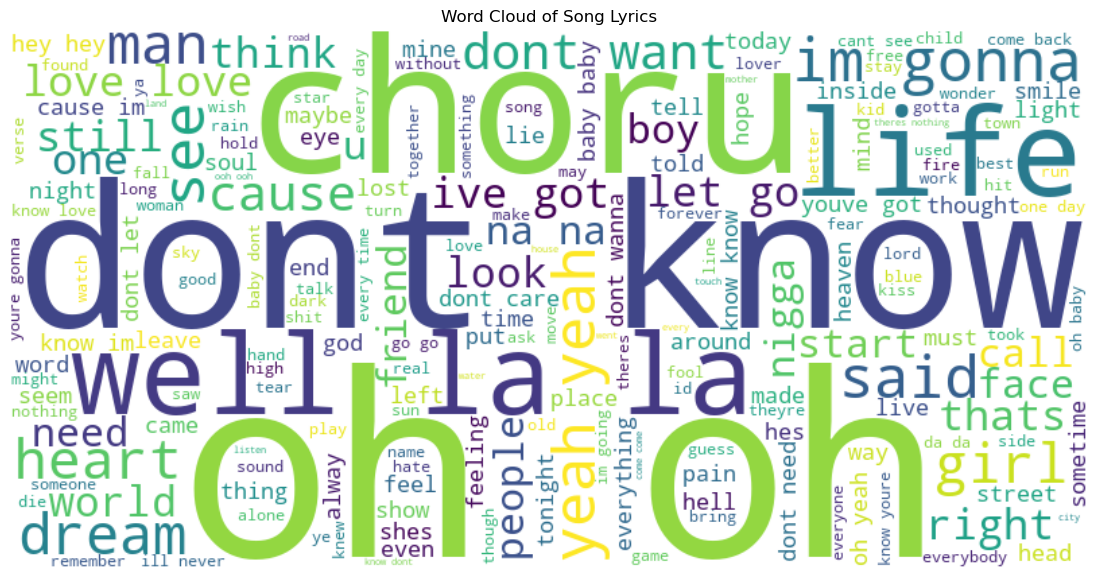

In [ ]:
# --- STEP 5: Additional Inferences ---
# For example, we can also use the provided genre column.
if "genre" not in df_processed.columns:
    raise KeyError("Expected a 'genre' column in the dataset.")

In [ ]:
# --- STEP 7: Train Machine Learning Models ---

## (A) Sentiment Model Training (Binary Classification)
# Use TF-IDF on cleaned lyrics.
tfidf_sentiment = TfidfVectorizer(max_features=5000, stop_words='english')
X_sentiment = tfidf_sentiment.fit_transform(df_processed["clean_lyrics"])
y_sentiment = df_processed["sentiment_label"]

X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(X_sentiment, y_sentiment,
                                                                      test_size=0.2, random_state=42)
sentiment_model = LogisticRegression(max_iter=1000, random_state=42)
sentiment_model.fit(X_train_sent, y_train_sent)

y_pred_sent = sentiment_model.predict(X_test_sent)
print("Sentiment Model Accuracy:", accuracy_score(y_test_sent, y_pred_sent))
print("Sentiment Classification Report:\n", classification_report(y_test_sent, y_pred_sent))

## (B) Genre Prediction Model Training (Multi-Class Classification)
# Use the genre column as labels.
# Note: Clean the genre string if needed.
df_processed["genre"] = df_processed["genre"].astype(str)
tfidf_genre = TfidfVectorizer(max_features=5000, stop_words='english')
X_genre = tfidf_genre.fit_transform(df_processed["clean_lyrics"])
y_genre = df_processed["genre"]

X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(X_genre, y_genre,
                                                                            test_size=0.2, random_state=42)
genre_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
genre_model.fit(X_train_genre, y_train_genre)

y_pred_genre = genre_model.predict(X_test_genre)
print("Genre Model Accuracy:", accuracy_score(y_test_genre, y_pred_genre))
print("Genre Classification Report:\n", classification_report(y_test_genre, y_pred_genre))

Accuracy on test set: 0.8902862098872506
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.77      3169
           1       0.89      0.97      0.93      8361

    accuracy                           0.89     11530
   macro avg       0.89      0.82      0.85     11530
weighted avg       0.89      0.89      0.88     11530

Confusion Matrix:
 [[2140 1029]
 [ 236 8125]]


In [ ]:
# --- STEP 8: Visualizations (Optional) ---
# For instance, plotting the average sentiment by genre
if "genre" in df_processed.columns:
    group_sentiment = df_processed.groupby("genre")["sentiment_score"].mean().reset_index()
    plt.figure(figsize=(12, 6))
    plt.bar(group_sentiment["genre"], group_sentiment["sentiment_score"], color="lightgreen")
    plt.xlabel("Genre")
    plt.ylabel("Average Sentiment Score")
    plt.title("Average Sentiment Score Across Music Genres")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

SQL connection closed.


In [ ]:
# --- STEP 9: Save Models with Pickle ---
resources_folder = "resources"
with open(os.path.join(resources_folder, "tfidf_sentiment.pkl"), "wb") as f:
    pickle.dump(tfidf_sentiment, f)
with open(os.path.join(resources_folder, "sentiment_model.pkl"), "wb") as f:
    pickle.dump(sentiment_model, f)

with open(os.path.join(resources_folder, "tfidf_genre.pkl"), "wb") as f:
    pickle.dump(tfidf_genre, f)
with open(os.path.join(resources_folder, "genre_model.pkl"), "wb") as f:
    pickle.dump(genre_model, f)

print("Models saved successfully.")

# --- STEP 10: Close Database Connection ---
conn.close()
print("SQL connection closed.")